# Creating Equidistant Timeseries

This notebooks shows functionality for creating equidistant timeseries in Pastas.
This is sometimes useful or necessary, i.e. the Stoffer-Toloi test for autocorrelation requires an
equidistant timeseries (that is allowed to have missing data).

In [11]:
import pastas as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
Numpy version: 1.21.2
Scipy version: 1.7.1
Pandas version: 1.3.3
Pastas version: 0.19.0b
Matplotlib version: 3.4.3


We define 2 pandas methods for resampling to an equidistant timeseries. 

1. The first creates a new equidistant index, rounded to the user-specified frequency. 
Then `Series.reindex()` is used with `method="nearest"`.
2. The second method rounds the series index down to the nearest user-specified frequency, then drops the duplicates before calling `Series.asfreq` with the user-specified frequency. This ensures no duplicates are in the resulting timeseries.

Pastas contains the function `pastas.utils.get_equidistant_timeseries()` which does something similar, but attempts to minimize the number of dropped points and ensures that each observation from the original timeseries is used only once in the resulting equidistant timeseries.


_**Note:** in terms of performance the pandas methods are undoubtedly faster._

In [38]:
def pandas_nearest(series, freq, tolerance=None):
    series = series.copy()
    # Create equidistant timeseries with Pandas
    idx = pd.date_range(series.index[0].floor(freq),
                        series.index[-1].ceil(freq),
                        freq=freq)
    spandas = series.reindex(idx, method="nearest", tolerance=tolerance)
    return spandas


def pandas_asfreq(series, freq):
    # Create equidistant timeseries with most frequent samples
    series = series.copy()
    series.index = series.index.floor(freq)
    spandas = (series
               .reset_index()
               .drop_duplicates(subset="index", keep="first", inplace=False)
               .set_index("index")
               .asfreq(freq)
               .squeeze()
               )
    return spandas


# Example 1

Lets create a timeseries spaced which is normally spaced with a frequency of 6 hours. The first and last measurement are shifted a bit later and earlier respectively. The two method compared here are the new function in Pastas and the Pandas reindex function.

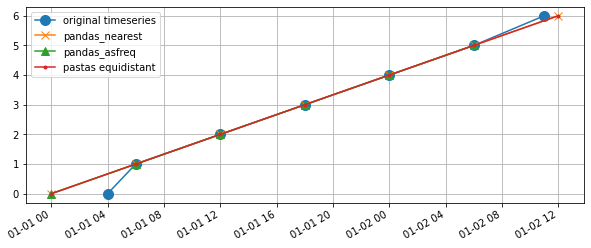

In [39]:
# Create timeseries
freq = "6H"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 04:00:00")
idx0[-1] = pd.Timestamp("2000-01-02 11:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))

# Create equidistant timeseries with Pastas
s_pd1 = pandas_nearest(series, freq)
s_pd2 = pandas_asfreq(series, freq)
s_pastas = ps.utils.get_equidistant_series(series, freq)

# Create figure
plt.figure(figsize=(10, 4))
ax = series.plot(marker="o", label="original timeseries", ms=10,)
s_pd1.plot(ax=ax, marker="x", ms=8, label="pandas_nearest")
s_pd2.plot(ax=ax, marker="^", ms=8, label="pandas_asfreq")
s_pastas.plot(ax=ax, marker=".", label="pastas equidistant")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("");


As we can see, both the pandas methods and the pastas method show expected behavior. 
The data at the beginning and at the end is shifted to the nearest equidistant timestamp.

# Example 2

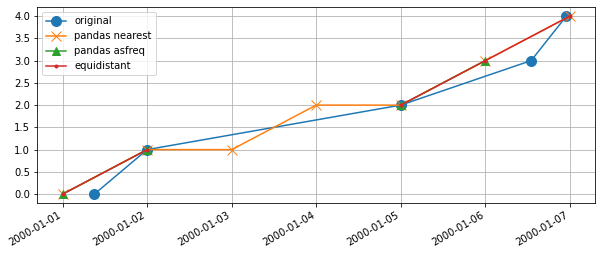

In [40]:
# Create timeseries
freq = "D"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 09:00:00")
del idx0[2]
del idx0[2]
idx0[-2] = pd.Timestamp("2000-01-06 13:00:00")
idx0[-1] = pd.Timestamp("2000-01-06 23:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))

# Create equidistant timeseries
s_pd1 = pandas_nearest(series, freq)
s_pd2 = pandas_asfreq(series, freq)
s_pastas = ps.utils.get_equidistant_series(series, freq)

# Create figure
plt.figure(figsize=(10, 4))
ax = series.plot(marker="o", label="original", ms=10)
s_pd1.plot(ax=ax, marker="x", ms=10, label="pandas nearest")
s_pd2.plot(ax=ax, marker="^", ms=8, label="pandas asfreq")
s_pastas.plot(ax=ax, marker=".", label="equidistant")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("");

In this example, the shortcomings of `pandas_nearest` are clearly visible. It duplicates observations from the original timeseries to fill the gaps. This can be solved by passing e.g. `tolerance="0.99{freq}"` to `Series.reindex()` in which case the gaps will not be filled. However, with very irregular timesteps this is not guaranteed to work and duplicates may still occur. The `pandas_asfreq` and pastas methods work as expected and use the available data to create a reasonable equidistant timeseries from the original data.

# Example 3

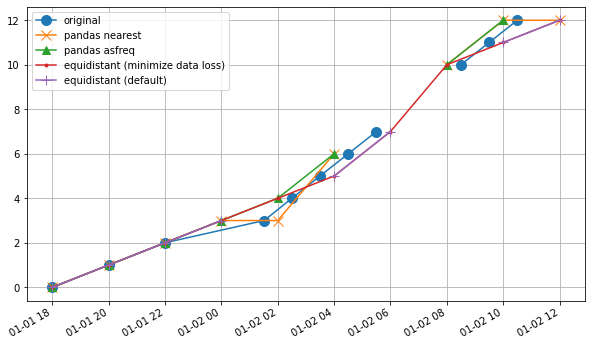

In [43]:
# Create timeseries
freq = "2H"
freq2 = "1H"
idx0 = pd.date_range("2000-01-01 18:00:00", freq=freq, periods=3).tolist()
idx1 = pd.date_range("2000-01-02 01:30:00", freq=freq2, periods=10).tolist()
idx0 = idx0 + idx1
idx0[3] = pd.Timestamp("2000-01-02 01:31:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))
series.iloc[8:10] = np.nan


# Create equidistant timeseries
s_pd1 = pandas_nearest(series, freq)
s_pd2 = pandas_asfreq(series, freq)
s_pastas1 = ps.utils.get_equidistant_series(
    series, freq, minimize_data_loss=True)
s_pastas2 = ps.utils.get_equidistant_series(
    series, freq, minimize_data_loss=False)


# Create figure
plt.figure(figsize=(10, 6))
ax = series.plot(marker="o", label="original", ms=10)
s_pd1.plot(ax=ax, marker="x", ms=10, label="pandas nearest")
s_pd2.plot(ax=ax, marker="^", ms=8, label="pandas asfreq")
s_pastas1.plot(ax=ax, marker=".", ms=6, label="equidistant (minimize data loss)")
s_pastas2.plot(ax=ax, marker="+", ms=10, label="equidistant (default)")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("");


In this example we can observe the following behavior in each method:
- `pandas_nearest` duplicates some observations in the equidistant timeseries.
- `pandas_asfreq` does quite well, but drops some observations near the gap in the original timeseries.
- the pastas method with the default option misses an observation right after the gap in the original timeseries.
- the pastas method with `minimize_data_loss=True` fills this gap, using as much data as possible from the original timeseries.

The results from the `pandas_asfreq` and pastas method are both good, but the pastas methods retains more of the original data.

# Example 4

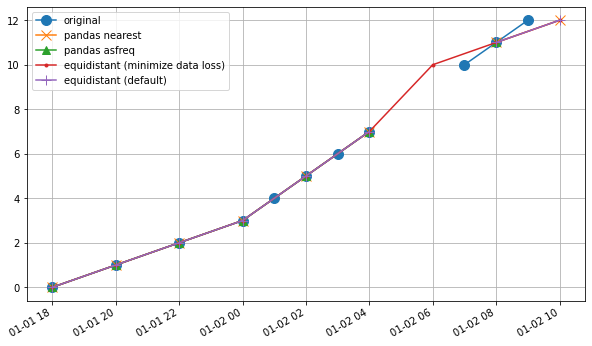

In [44]:
# Create timeseries
freq = "2H"
freq2 = "1H"
idx0 = pd.date_range("2000-01-01 18:00:00", freq=freq, periods=3).tolist()
idx1 = pd.date_range("2000-01-02 00:00:00", freq=freq2, periods=10).tolist()
idx0 = idx0 + idx1
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))
series.iloc[8:10] = np.nan

# Create equidistant timeseries
s_pd1 = pandas_nearest(series, freq)
s_pd2 = pandas_asfreq(series, freq)
s_pastas1 = ps.utils.get_equidistant_series(
    series, freq, minimize_data_loss=True)
s_pastas2 = ps.utils.get_equidistant_series(
    series, freq, minimize_data_loss=False)

# Create figure
plt.figure(figsize=(10, 6))
ax = series.plot(marker="o", label="original", ms=10)
s_pd1.plot(ax=ax, marker="x", ms=10, label="pandas nearest")
s_pd2.plot(ax=ax, marker="^", ms=8, label="pandas asfreq")
s_pastas1.plot(ax=ax, marker=".", ms=6,
               label="equidistant (minimize data loss)")
s_pastas2.plot(ax=ax, marker="+", ms=10, label="equidistant (default)")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("")


Similar to the previous example, the pastas method retains the most data from the original timeseries. In this case both pandas methods perform well, but do omit some of the original data at the end of the timeseries or near the gap in the original timeseries.